<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## *Quantum_chemistry*



## Introduction


In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_pauli,trial_funtion_optimization
from tools.optimizationtools import cost_function, make_Hamiltonian, parse_hamiltonian_file, text_to_ham


Hamtext=parse_hamiltonian_file("H2Equilibrium.txt")

In [20]:
# Set parameters 
n=2
m=2 #depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
file_name='H2Equilibrium.txt'
theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1000



In [27]:
def eval_hamiltonian(n,m,theta,file_name,device):


    ham_array=parse_hamiltonian_file(file_name);
    
    avg_energy=0
    var_energy=0
    std_energy=0
    
    
    circuits=[]
    trial_circuit=[]
    print(ham_array)
    print(math.ceil(len(ham_array)/2))
    Q_program = QuantumProgram()
    Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])
    
    
    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    
    for i in range(math.ceil(len(ham_array)/2)):     


        trial_circuit.append(trial_circuit_pauli(n,m,theta,entangler_map,ham_array[i*2]))
        circuits.append("trial_circuit_label"+str(i))
        Q_program.add_circuit(circuits[i],trial_circuit[i])
        print(Q_program.get_qasm(circuits[i]))
       
        
    
    Q_program.execute(circuits,device,shots)

    
    
    
    # COMPUTE MEAN ENERGY AND STANDARD ERROR ASSOCIATED TO EACH PAULI TERM AND THEN SUM THEM INTO AVG_ENERGY
    
    pauli_energy=np.zeros(math.ceil(len(ham_array)/2))
    pauli_var=np.zeros(math.ceil(len(ham_array)/2))

    
    for i in range(math.ceil(len(ham_array)/2)):#loop over Pauli terms
       
        countsloop=Q_program.get_counts(circuits[i])
        print(countsloop)
        
            
        for j in countsloop:  #loop over counts of a Pauli measurement outcome
            pauli_avg_count=float(ham_array[2*i+1])
            for k in range(n):  # loop over qubits 
                
                if ham_array[2*i][k]!='I' and j[(n-1)-k]=="1":
                    pauli_avg_count=-pauli_avg_count # put minus sign on given counts of given Pauli
            
            pauli_energy[i]+=pauli_avg_count*countsloop[j]/shots
           
        for j in countsloop:  #loop over counts of a Pauli measurement outcome
            pauli_avg_count=float(ham_array[2*i+1])
            for k in range(n):  # loop over qubits 
                
                if ham_array[2*i][k]!='I' and j[(n-1)-k]=="1":
                    pauli_avg_count=-pauli_avg_count # put minus sign on given counts of given Pauli
            
            pauli_var[i]+=countsloop[j]*math.pow((pauli_avg_count-pauli_energy[i]),2)/shots
        
   

    
    for i in range(math.ceil(len(ham_array)/2)): 
        avg_energy+=pauli_energy[i]
        var_energy+=pauli_var[i]
        
        
    std_energy=np.sqrt(var_energy)/np.sqrt(shots)
    
    
    
    
    
    return avg_energy,std_energy
                        

In [28]:
eval_hamiltonian(n,m,theta,'H2Equilibrium.txt',device)

['II', -1.0523760606256514, 'ZI', 0.39793570529466216, 'IZ', 0.39793570529466227, 'XX', 0.18093133934472627]
4
OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
h q[1];
barrier q[0],q[1];
barrier q[0],q[1];
ry(0.000000000000000) q[0];
rz(0.000000000000000) q[0];
ry(0.000000000000000) q[1];
rz(0.000000000000000) q[1];
cz q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
h q[1];
barrier q[0],q[1];
barrier q[0],q[1];
ry(0.000000000000000) q[0];
rz(0.000000000000000) q[0];
ry(0.000000000000000) q[1];
rz(0.000000000000000) q[1];
cz q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
h q[0];
h q[1];
barrier q[0],q[1];
barrier q[0],q[1];
ry(0.000000000000000) q[0];
rz(0.000000000000000) q[0];
ry(0.000000000000000) q[1];
rz(0.000000000000000) q[1];
cz q[0],q[1];
measure q[0] -> c[0];
measure q[1] -> c[1];

OPENQASM 2.0;
include "qelib1.inc";
qreg

(-1.0868893803191086, 0.018681066585464059)

### Optimizing the potential energy surface 

[ 2.645885    1.76392333  1.3229425   1.058354    0.88196167  0.75596714
  0.66147125  0.58797444  0.529177    0.48107     0.44098083  0.40705923
  0.37798357  0.35278467  0.33073562  0.31128059  0.29398722  0.27851421
  0.2645885   0.25198905  0.240535    0.23007696  0.22049042  0.2116708
  0.20352962  0.19599148  0.18899179  0.18247483  0.17639233  0.17070226
  0.16536781  0.16035667  0.15564029  0.15119343  0.14699361  0.14302081
  0.13925711  0.13568641  0.13229425]
[ 0.15748025 -0.60180521 -0.91414947 -1.05515961 -1.11628663 -1.13618916
 -1.13414709 -1.12056012 -1.10114996 -1.07919329 -1.0567411  -1.03518696
 -1.01546874 -0.99814919 -0.98347336 -0.9714276  -0.96181708 -0.9543389
 -0.94864106 -0.94437519 -0.94122469 -0.93892324 -0.93725423 -0.93605388
 -0.93519571 -0.9345834  -0.93415102 -0.93384712 -0.93363208 -0.93348288
 -0.93338099 -0.93331063 -0.93326066 -0.93322776 -0.93320777 -0.93319224
 -0.93318187 -0.93317572 -0.93317176]


/Users/amezzac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


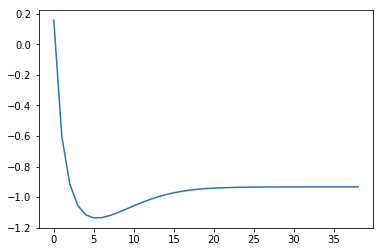

In [6]:
# Parameters

molecule='H2' #name of the molecule folder
Z1=1
Z2=1
min_distance=.2
max_distance=4
number_of_points=39


####################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)

for i in range(number_of_points):

    
    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        #print(mol_distance)
        distance=mol_distance/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance)+'.txt'
        text_to_ham(ham_text)
        eigen=la.eig(text_to_ham(ham_text))
        electr_energy[i]=np.amin(eigen[0])
        

print(coulomb_repulsion)
print(electr_energy+coulomb_repulsion)
plt.plot(electr_energy+coulomb_repulsion)   
        